In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
import warnings
warnings.filterwarnings(action='once')

In [3]:
cpi_serie = pd.read_csv(r"..\Datos\cpi_ec.csv",index_col=0)

<AxesSubplot:>

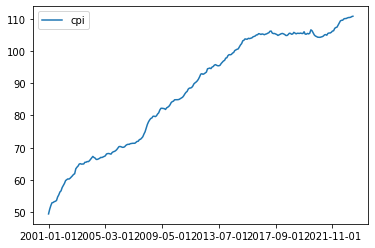

In [4]:
cpi_serie.columns = ['cpi']
cpi_serie.plot()

In [5]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [6]:
def grid_search(degree, C_l,coef, eps, gamma, error):
    '''
    Grid search process to find optimal solution within a list of given parameters
    '''
    best_e=float('inf')
    test_y = cpi_serie[-tt-tv:-tv].cpi.tolist()

    for d in degree:
        print(d)
        for c in C_l:
            for co in coef:
                for ep in eps:
                    for g in gamma:
                        try:
                            model = SVR(kernel='poly', degree=d, C=c, cache_size=200, coef0=co, epsilon=ep, gamma=g,
            max_iter=100000000, shrinking=True, tol=0.001, verbose=False)
                            model.fit(x_train, y_train[:,0])

                            y_test_pred = model.predict(x_test).reshape(-1,1)
                            xtr = np.array([x_test[0]])
                            y_test_pred = []
                            for _ in range(len(test_y)):
                                pred = model.predict(xtr).reshape(-1,1)
                                xtr = np.array([np.concatenate((xtr[0],pred[0]))[1:]])
                                y_test_pred.append(scaler.inverse_transform(pred)[0][0])
                            # Scaling the predictions
                            #y_test_pred = scaler.inverse_transform(y_test_pred)

                            errors=forecast_accuracy(y_test_pred, test_y)
                            e = errors[error]
                            if e<best_e:
                                opt_params = [d,c,co,ep,g]
                                best_e=e 
                                print(opt_params,best_e)
                        except:
                            print("Error")
                    
    print('BEST: ',opt_params, best_e)
    return opt_params

In [7]:
t =12
tt = 12
tv = 5

train= cpi_serie[:-tt-tv] #Reduced
test = cpi_serie[-tt-tv-t:-tv]
validation = cpi_serie[-tv-t:]


scaler = MinMaxScaler()

test_data = scaler.fit_transform(test)
train_data = scaler.transform(train)
val_data = scaler.transform(validation)

# Converting to numpy arrays
timesteps =t+1

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
print(train_data_timesteps.shape)

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(test_data_timesteps.shape)

val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
print(val_data_timesteps.shape)

(240, 13)
(12, 13)
(5, 13)


In [8]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(240, 12) (240, 1)
(12, 12) (12, 1)
(5, 12) (5, 1)


In [ ]:
'''
#Uncomment to find the best hyperparameters
d1 = [2]
c1 = [0.01,0.1,0.5, 1,3]
coef1 = [5,10,15,20]
eps1 = [0.001,0.01,0.1,1,2]
gamma1 = ['scale',10,15,20]

opt_params = grid_search(d1, c1,coef1, eps1, gamma1, 'mae')
'''

In [9]:
model = SVR(kernel='poly', degree=2, C=0.01, coef0=15, epsilon=0.001, gamma=15,
                max_iter=100000000, cache_size=200, shrinking=True, tol=0.001, verbose=False)

model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)
y_val_pred = model.predict(x_val).reshape(-1,1)

# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_val_pred = scaler.inverse_transform(y_val_pred)

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [10]:
x = forecast_accuracy([i[0] for i in y_train_pred], cpi_serie[t:-tt-tv].cpi.tolist())
print(x)
xt=forecast_accuracy([i[0] for i in y_test_pred], cpi_serie[-tt-tv:-tv].cpi.tolist())
print(xt)
xv=forecast_accuracy([i[0] for i in y_val_pred], cpi_serie[-tv:].cpi.tolist())
print(xv)

{'mape': 0.003586431078300342, 'me': 0.03663349887052222, 'mae': 0.28690893274576096, 'mpe': 0.0005439082807832778, 'rmse': 0.3953880191452698, 'corr': 0.9997000237632122}
{'mape': 0.003251946773049585, 'me': -0.32253205915885275, 'mae': 0.35369186600326924, 'mpe': -0.0029688045027686546, 'rmse': 0.44794696401173095, 'corr': 0.9708296592363687}
{'mape': 0.0008049531008149738, 'me': 0.011170927268400988, 'mae': 0.08892463852427283, 'mpe': 0.00010164598566088805, 'rmse': 0.09709955885166068, 'corr': 0.8147400369884097}


In [11]:
xtr = np.array([x_test[0]])
y_test_pred = []
for _ in range(tt):
    pred = model.predict(xtr).reshape(-1,1)
    xtr = np.array([np.concatenate((xtr[0],pred[0]))[1:]])
    y_test_pred.append(scaler.inverse_transform(pred)[0][0])

xvr = np.array([x_val[0]])
y_val_pred = []
for _ in range(tv):
    pred = model.predict(xvr).reshape(-1,1)
    xvr = np.array([np.concatenate((xvr[0],pred[0]))[1:]])
    y_val_pred.append(scaler.inverse_transform(pred)[0][0])
xt=forecast_accuracy(y_test_pred, cpi_serie[-tt-tv:-tv].cpi.tolist())
print(xt)

xv=forecast_accuracy(y_val_pred, cpi_serie[-tv:].cpi.tolist())
print(xv)

{'mape': 0.01917156178936699, 'me': -2.0971725245433297, 'mae': 2.0971725245433297, 'mpe': -0.01917156178936699, 'rmse': 2.2754063532872473, 'corr': 0.9537267470790588}
{'mape': 0.0009535001958785472, 'me': 0.06776165311490559, 'mae': 0.10539400226961107, 'mpe': 0.0006125039186521475, 'rmse': 0.11452763939129061, 'corr': 0.9305563654709247}


In [12]:
x_final = np.array([x_val[-1]])
y_final_pred = []
for i in range(9):
    pred = model.predict(x_final).reshape(-1,1)
    x_final = np.array([np.concatenate((x_final[0],pred[0]))[1:]])
    y_final_pred.append(scaler.inverse_transform(pred)[0][0])
y_final_pred

[110.7023702966958,
 110.6846321318866,
 110.74515554600914,
 110.75104702205113,
 110.69687982916525,
 110.75140699864026,
 110.7752604801868,
 110.77316204105622,
 110.77437667646852]

In [13]:
np.savetxt(r'..\Datos\svr_prediction.csv',np.array(y_final_pred), fmt = '%f', delimiter=",")   